In [1]:
from src.utils import read_jsonl, write_jsonl
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def is_president(x):
    return re.search(r'pr[ée]sident', x['mention_text'], re.I)

def is_rapporteur(file_names):   
    def wrapped_is_rapporteur(x):
        return x['decision_id'] in file_names and re.search(r'rapporteur', x['mention_text'], re.I)
    return wrapped_is_rapporteur

PERSONS = {
    'frey':[is_president],
    'vedel':[is_rapporteur(['#DC-82-139', '#DC-82-142', '#DC-82-144', '#DC-82-145'])],
    'segalat':[is_rapporteur(['#DC-82-140', '#DC-82-143', '#L-82-129', '#DC-82-154'])],
    'gros':[is_rapporteur(['#DC-82-141', '#DC-82-146'])],
    'lecourt':[is_rapporteur(['#DC-82-137', '#DC-81-134', '#L-82-127'])],
    'monnerville':[],
    'brouillet':[],
    'peretti':[is_rapporteur(['#L-82-128'])],
    'joxe':[],
    'giscard':[]
}

In [4]:
df = pd.read_csv('data/82_speaker_target.csv')
df.describe(include='all')

,file_name,decision_id,sent_id,sent_text,mention_start,mention_end,mention_text,is_speaker,is_target
count,490,466,490.000000,490,490.000000,490.000000,490,490,490
unique,11,13,NaN,329,NaN,NaN,30,2,2
top,PV1982-11-18,#DC-82-146,NaN,"Ce projet est adopté, Messieurs MONNERVILLE, J...",NaN,NaN,VEDEL,True,False
freq,111,71,NaN,9,NaN,NaN,72,273,346
mean,NaN,NaN,453.828571,NaN,43.683673,51.757143,NaN,NaN,NaN
std,NaN,NaN,238.444729,NaN,51.950896,53.600203,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,0.000000,10.000000,NaN,NaN,NaN
25%,NaN,NaN,266.250000,NaN,9.000000,16.000000,NaN,NaN,NaN
50%,NaN,NaN,480.000000,NaN,12.000000,21.000000,NaN,NaN,NaN
75%,NaN,NaN,655.750000,NaN,64.000000,70.000000,NaN,NaN,NaN


In [6]:
df['sent_text'].values

array(['Monsieur le Président remercie Monsieur LECOURT de son rapport et déclare que la discussion générale est ouverte.',
       'Monsieur le Président remercie Monsieur LECOURT de son rapport et déclare que la discussion générale est ouverte.',
       "Monsieur VEDEL, après avoir souligné que la procédure de l'article 38 est de nature à réduire l'étendue du contrôle du Conseil constitutionnel qui, après l'examen de la loi d'habilitation, n'est plus susceptible de porter que sur la loi de ratification qui n'est examinée bien souvent que très tardivement par le Parlement, précise, sur le fond, qu'il redoute que l'appréciation du critère de l'âge n'autorise le Gouvernement à instaurer un système extrêmement contraignant.",
       'Monsieur GROS rappelle que bien souvent les retraites sont alimentées par des cotisations volontaires.',
       "Monsieur BROUILLET se déclare sensible à la première partie de l'argumentation de Monsieur VEDEL sur la diminution du champ de contrôle du Conseil

In [ ]:
Listes des personnes : Monsieur MONNERVILLE, Monsieur JOXE, Monsieur GROS, Monsieur BROUILLET, Monsieur SEGALAT
Qui parmi les personnes cité ci-dessus est mentionné dans la phrase : "Monsieur MONNERVILLE approuve pleinement le raisonnement que viennent de développer Messieurs GROS et BROUILLET.""

In [4]:
def match_person(x):
    for k, v in PERSONS.items():
        if re.search(f'{k}', x['mention_text'], re.I):
            return k
        for func in v:
            if func(x):
                return k
    return ''    

In [5]:
df['person'] = df.apply(match_person, axis=1)

In [6]:
df['person'].value_counts()

segalat        86
vedel          80
frey           71
gros           64
lecourt        60
monnerville    33
brouillet      32
peretti        32
               22
joxe            9
giscard         1
Name: person, dtype: int64

In [7]:
df[df['person'] == '']['mention_text']

32                                      Premier ministre
36                                      Premier ministre
41                                      Premier ministre
46                                            rapporteur
60                                                 FOYER
112                                             DEFFERRE
113                                             DEFFERRE
182                                     premier ministre
183                                     Premier ministre
234                              ministre chargé du Plan
239                 ministre chargé du Plan et du budget
241    ministre chargé du Plan et de l'aménagement du...
298                                           Rapporteur
300                                           Rapporteur
309                                          SANGUINETTI
315                                                DEBRE
316                               ministre de la Défense
317                            

In [131]:
sents = []
last_speaker = None

decision_id, decision = list(df.groupby(['decision_id']))[0]
for sent_id, sent in enumerate(decision.groupby('sent_id')):
    sent = sent[1]
    sents.append({
        'id':sent_id,
        'speaker':last_speaker,
        'targets':[]
    })
    for mention in sent.values:
        m, s, t, p = mention[6:]
        if s == True:
            sents[-1]['speaker'] = last_speaker = p
        if t == True:
            sents[-1]['targets'].append(p)

NODE_SIZE = 4000
SIZE = 32

X_SIZE = 2
Y_SIZE = 2

last_nodes = {
    'frey':None,
    'vedel':None,
    'segalat':None,
    'gros':None,
    'lecourt':None,
    'monnerville':None,
    'brouillet':None,
    'peretti':None,
    'joxe':None,
    'giscard':None
}

print(sents)

g = nx.DiGraph()
pos = {}

last_node = None
for sent in sents:
    speaker, sent_id = sent['speaker'], sent['id']
    current_node = f"{speaker}_{sent_id}"

    pos.update({current_node:(float(sent_id*X_SIZE), .0)})

    if last_node:
        g.add_edge(last_node, current_node)

    for target in sent['targets']:
        if target in last_nodes:       
            g.add_edge(current_node, last_nodes[target])
        else:
            g.add_edge(current_node, f'{target}_{sent_id}')
            pos.update({f'{target}_{sent_id}':(float(sent_id * X_SIZE), float(Y_SIZE))})

    last_nodes[speaker] = last_node = current_node

print(len(sents))
print(pos)
# pos = nx.   (pos, scale=1)
# print(pos)

# fig, ax = plt.subplots(figsize=(16,16))
plt.figure(figsize=(32, 4))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.autoscale(False)
plt.xticks(list(range(SIZE)), list(range(SIZE)))
plt.yticks(list(range(4)), list(range(4)))
plt.title(decision_id)

nx.draw_networkx_nodes(g, pos,  node_size=NODE_SIZE)
nx.draw_networkx_edges(
    g, pos,  node_size=NODE_SIZE,
    connectionstyle="arc3,rad=0.45"  # <-- THIS IS IT
)
nx.draw_networkx_labels(g, pos,  labels={n: n.split('_')[0][:7] for n in g})
# # ax.set_xlim(left=-X_SIZE, right=len(sents)*X_SIZE)
# ax.margins(0.05)
# plt.grid(True, which='both')
# plt.axis("on")
# # plt.axis("off")

# plt.show()


#     # print(g[1].loc[i, 'sent_id'], g[1].loc[i, 'person'], g[1].loc[i, 'is_speaker'], g[1].loc[i, 'is_target'])

[{'id': 0, 'speaker': 'frey', 'targets': ['lecourt']}, {'id': 1, 'speaker': 'vedel', 'targets': []}, {'id': 2, 'speaker': 'gros', 'targets': []}, {'id': 3, 'speaker': 'brouillet', 'targets': ['vedel']}, {'id': 4, 'speaker': 'segalat', 'targets': ['brouillet']}, {'id': 5, 'speaker': 'joxe', 'targets': []}, {'id': 6, 'speaker': 'monnerville', 'targets': []}, {'id': 7, 'speaker': 'frey', 'targets': ['brouillet']}, {'id': 8, 'speaker': 'segalat', 'targets': []}, {'id': 9, 'speaker': 'vedel', 'targets': ['segalat']}, {'id': 10, 'speaker': 'monnerville', 'targets': []}, {'id': 11, 'speaker': 'lecourt', 'targets': ['monnerville']}, {'id': 12, 'speaker': 'lecourt', 'targets': []}, {'id': 13, 'speaker': 'vedel', 'targets': []}, {'id': 14, 'speaker': 'lecourt', 'targets': ['vedel']}, {'id': 15, 'speaker': 'frey', 'targets': []}]


C:\Users\pierr\AppData\Local\Temp\ipykernel_13740\951152156.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  decision_id, decision = list(df.groupby(['decision_id']))[0]


ValueError: None cannot be a node

In [ ]:
from pyvis import network as net
import networkx as nx

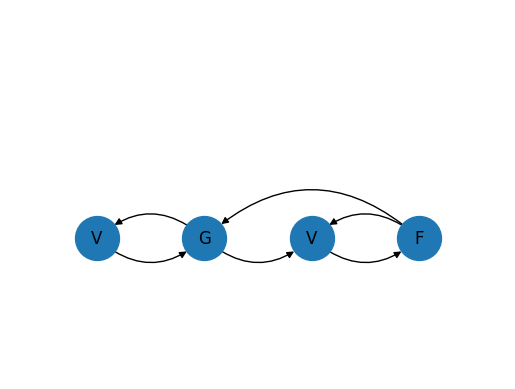

In [71]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edge('V_0', 'G_0')
G.add_edge('G_0', 'V_0')
G.add_edge('G_0', 'V_1')
G.add_edge('V_1', 'F_0')    
G.add_edge('F_0', 'G_0')    
G.add_edge('F_0', 'V_1')    


# explicitly set positions
pos = {'V_0': (0, 0), 'G_0': (1*5,0), 'V_1': (2*5, 0), 'F_0': (3*5, 0)}


# Compute position of nodes
# pos = nx.kamada_kawai_layout(G)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=1000)
nx.draw_networkx_edges(
    G, pos, arrows=True, node_size=1000,
    connectionstyle="arc3,rad=0.45"  # <-- THIS IS IT
)
nx.draw_networkx_labels(G, pos, labels={n: n.split('_')[0] for n in G})

# nx.draw_networkx(G, pos, **options)
# nx.draw_networkx(G, pos=nx.spring_layout(G),  **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")

plt.show()